# Machine Translation Based on Seq2Seq

In [4]:
import re
import io
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [5]:
# Prepare datasets
def preprocess_sentence(w):   
    '''
    w：sentence
    '''
    w = re.sub(r'([?.!,])', r' \1 ', w)  # add spaces before and after punctuation marks in sentences
    w = re.sub(r"[' ']+", ' ', w)  # remove multiple spaces from sentences
    w = '<start> ' + w + ' <end>'  # add start and end marks to the sentences so that the model can predict them
    return w

en_sentence = 'I like this book'
sp_sentence = '我喜欢这本书'
print('The output before preprocessing is: ', '\n', preprocess_sentence(en_sentence))
print('The output before preprocessing is: ', '\n', str(preprocess_sentence(sp_sentence)), 'utf-8', '\n')

The output before preprocessing is:  
 <start> I like this book <end>
The output before preprocessing is:  
 <start> 我喜欢这本书 <end> utf-8 



In [6]:
# Clean up sentences, remove accents, and return word pairs in format [English, Chinese]
def create_dataset(path, num_examples):
    '''
    path：file path
    num_examples：the amount of data selected
    '''
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)

path_to_file = '../data/en-ch.txt'  # path to read the file
en, sp = create_dataset(path_to_file, None)  # cosolidate and read the data
# None--> indicates that the function does not limit the number of sentences read

In [7]:
# Maximum sentence length
def max_length(tensor):
    '''
    tensor：the tensor of text composition
    '''
    return max(len(t) for t in tensor)

In [8]:
def tokenize(lang):
    '''
    lang：text to be processed
    '''
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang) # generate a document dictionary
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [9]:
# Create a clean input/output pair
def load_dataset(path, num_examples=None):
    '''
    path：file path
    num_examples：the amount of data selected
    '''
    # create an index, imput the cleaned words, output word pairs
    targ_lang, inp_lang = create_dataset(path, num_examples) 
    # establish the word vector of Chinese sentence, fill all tensors-->sentences has the same dimension
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)   
    # establish the word vector of English sentence, fill all tensors-->sentences has the same dimension
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)  
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
num_examples = 2000  # size of the vocabulary (词量)
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, 
                                                                num_examples)
# calculate the maximum length of the target tensor
max_length_targ, max_length_inp = max_length(target_tensor), max_length(
    input_tensor) 

# the training set and the verification set are divided by the ratio of 8:2
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
        input_tensor, target_tensor, test_size=0.2) 

In [11]:
# Verify the correctness of the data-->the representation of the output word and the word mapping index
def convert(lang, tensor):
    '''
    lang：text to be processed
    tensor：the tensor of text composition
    '''
    for t in tensor:
        if t != 0:    
            print ('%d ----> %s' % (t, lang.index_word[t]))

print('The output before preprocessing is: ')
print('Input language: Word mapping index')
convert(inp_lang, input_tensor_train[0])
print('Target language: Word mapping index')
convert(targ_lang, target_tensor_train[0])

The output before preprocessing is: 
Input language: Word mapping index
1 ----> <start>
512 ----> 汤姆告诉了他。
2 ----> <end>
Target language: Word mapping index
1 ----> <start>
10 ----> tom
330 ----> told
39 ----> him
3 ----> .
2 ----> <end>


In [12]:
# Create the tf.data dataset
BUFFER_SIZE = len(input_tensor_train)  # the maximum number of elements to be added to the buffer
BATCH_SIZE = 64  # the number of samples selected for each training
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE  # the number of iteration steps required to train a round
embedding_dim = 256  # dimension of word vector
units = 1024  # number of neurons
vocab_inp_size = len(inp_lang.word_index)+1  # input the size of the vocabulary
vocab_tar_size = len(targ_lang.word_index)+1  # output the size of the vocabulary
dataset = tf.data.Dataset.from_tensor_slices((
    input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)  # build training set
example_input_batch, example_target_batch = next(iter(dataset))

In [14]:
# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz  # the number of samples selected for each training
        self.enc_units = enc_units  # number of neurons
        #input
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)  
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [15]:
# Construct the encoder network structure    
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()  # input hidden sample
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)  
print('Encoder output shape:', '\n', ' (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder hidden state shape:', '\n', ' (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: 
  (batch size, sequence length, units) (64, 6, 1024)
Encoder hidden state shape: 
  (batch size, units) (64, 1024)


In [16]:
# Attention mechanism
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):

        hidden_with_time_axis = tf.expand_dims(query, 1)  
        # Calculate the attention weight value
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))  
        # attention_weights shape == （batch size，max_length，1）
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector sum shape == (batch size, hidden layer size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
    
attention_layer = BahdanauAttention(10)  # construct attention network structure
attention_result, attention_weights = attention_layer(
    sample_hidden, sample_output)
print('Attentional result shape: ', '\n', ' (batch size, units) {}'.format(attention_result.shape)) 
print('Attention weight shape: ', '\n', ' (batch_size, sequence_length, 1) {}'.format(attention_weights.shape))

Attentional result shape:  
  (batch size, units) (64, 1024)
Attention weight shape:  
  (batch_size, sequence_length, 1) (64, 6, 1)


In [17]:
# Decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz  # the number of samples selected for each training
        self.dec_units = dec_units  # number of neurons
        # input layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)  
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # call attention model
        self.attention = BahdanauAttention(self.dec_units)
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x) 
        output = tf.reshape(output, (-1, output.shape[2])) 

        x = self.fc(output)  
        return x, state, attention_weights
    
# build decoder network structure
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)  
sample_decoder_output, states, attention_weight = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)
print('Decoder output shape:', '\n', ' (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: 
  (batch_size, vocab size) (64, 1166)


In [19]:
# Optimizer
optimizer = tf.keras.optimizers.Adam()  
# Loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')  

# Define the optimizer and the loss function
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [20]:
import os
import time

In [21]:
checkpoint_dir = '../tmp/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)  # save the model
# train the model
def train(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)  # build encoder
        dec_hidden = enc_hidden  
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            # transfer the encoder output to the decoder
            predictions, dec_hidden, dec_predictions = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
        loss = loss / int(targ.shape[1])  # calculate average loss
    batch_loss = loss.numpy()  # convert losses to numpy arrays
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [23]:
# Begin training
EPOCHS = 50
loss = []
from tqdm import  tqdm
for epoch in tqdm(range(EPOCHS)):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()  # initializes the hidden layer
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        # print(batch)
        batch_loss = train(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))
            loss.append(round(batch_loss, 3))
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 4.5246


  2%|▏         | 1/50 [00:29<24:24, 29.88s/it]

Epoch 2 Batch 0 Loss 2.5725


  4%|▍         | 2/50 [00:55<22:05, 27.62s/it]

Epoch 3 Batch 0 Loss 2.3591


  6%|▌         | 3/50 [01:28<23:26, 29.93s/it]

Epoch 4 Batch 0 Loss 2.0929


  8%|▊         | 4/50 [02:02<24:02, 31.36s/it]

Epoch 5 Batch 0 Loss 1.9503


 10%|█         | 5/50 [02:27<21:48, 29.08s/it]

Epoch 6 Batch 0 Loss 1.9651


 12%|█▏        | 6/50 [03:00<22:26, 30.60s/it]

Epoch 7 Batch 0 Loss 1.7096


 14%|█▍        | 7/50 [03:33<22:25, 31.30s/it]

Epoch 8 Batch 0 Loss 1.7637


 16%|█▌        | 8/50 [04:03<21:43, 31.03s/it]

Epoch 9 Batch 0 Loss 1.6701


 18%|█▊        | 9/50 [04:26<19:22, 28.35s/it]

Epoch 10 Batch 0 Loss 1.5456


 20%|██        | 10/50 [04:54<18:46, 28.17s/it]

Epoch 11 Batch 0 Loss 1.3991


 22%|██▏       | 11/50 [05:23<18:34, 28.57s/it]

Epoch 12 Batch 0 Loss 1.3858


 24%|██▍       | 12/50 [05:53<18:21, 28.99s/it]

Epoch 13 Batch 0 Loss 1.2040


 26%|██▌       | 13/50 [06:18<17:10, 27.85s/it]

Epoch 14 Batch 0 Loss 1.2012


 28%|██▊       | 14/50 [06:39<15:27, 25.76s/it]

Epoch 15 Batch 0 Loss 1.2042


 30%|███       | 15/50 [07:00<14:13, 24.39s/it]

Epoch 16 Batch 0 Loss 1.0724


 32%|███▏      | 16/50 [07:23<13:34, 23.96s/it]

Epoch 17 Batch 0 Loss 0.9994


 34%|███▍      | 17/50 [07:47<13:03, 23.73s/it]

Epoch 18 Batch 0 Loss 0.9163


 36%|███▌      | 18/50 [08:11<12:42, 23.83s/it]

Epoch 19 Batch 0 Loss 0.8994


 38%|███▊      | 19/50 [08:37<12:38, 24.48s/it]

Epoch 20 Batch 0 Loss 0.7902


 40%|████      | 20/50 [09:02<12:19, 24.64s/it]

Epoch 21 Batch 0 Loss 0.7896


 42%|████▏     | 21/50 [09:26<11:47, 24.40s/it]

Epoch 22 Batch 0 Loss 0.6966


 44%|████▍     | 22/50 [09:52<11:37, 24.92s/it]

Epoch 23 Batch 0 Loss 0.6455


 46%|████▌     | 23/50 [10:14<10:53, 24.19s/it]

Epoch 24 Batch 0 Loss 0.5670


 48%|████▊     | 24/50 [10:36<10:12, 23.55s/it]

Epoch 25 Batch 0 Loss 0.5822


 50%|█████     | 25/50 [10:59<09:40, 23.20s/it]

Epoch 26 Batch 0 Loss 0.6073


 52%|█████▏    | 26/50 [11:22<09:19, 23.29s/it]

Epoch 27 Batch 0 Loss 0.5729


 54%|█████▍    | 27/50 [11:47<09:04, 23.67s/it]

Epoch 28 Batch 0 Loss 0.4758


 56%|█████▌    | 28/50 [12:09<08:29, 23.16s/it]

Epoch 29 Batch 0 Loss 0.4815


 58%|█████▊    | 29/50 [12:33<08:12, 23.45s/it]

Epoch 30 Batch 0 Loss 0.4439


 60%|██████    | 30/50 [12:58<08:00, 24.05s/it]

Epoch 31 Batch 0 Loss 0.3934


 62%|██████▏   | 31/50 [13:24<07:44, 24.46s/it]

Epoch 32 Batch 0 Loss 0.3495


 64%|██████▍   | 32/50 [13:55<07:58, 26.58s/it]

Epoch 33 Batch 0 Loss 0.2776


 66%|██████▌   | 33/50 [14:23<07:39, 27.05s/it]

Epoch 34 Batch 0 Loss 0.2955


 68%|██████▊   | 34/50 [14:56<07:37, 28.60s/it]

Epoch 35 Batch 0 Loss 0.2526


 70%|███████   | 35/50 [15:26<07:17, 29.16s/it]

Epoch 36 Batch 0 Loss 0.2395


 72%|███████▏  | 36/50 [15:55<06:48, 29.16s/it]

Epoch 37 Batch 0 Loss 0.1969


 74%|███████▍  | 37/50 [16:25<06:22, 29.43s/it]

Epoch 38 Batch 0 Loss 0.1930


 76%|███████▌  | 38/50 [16:56<05:57, 29.83s/it]

Epoch 39 Batch 0 Loss 0.1798


 78%|███████▊  | 39/50 [17:26<05:28, 29.83s/it]

Epoch 40 Batch 0 Loss 0.1421


 80%|████████  | 40/50 [17:59<05:09, 30.94s/it]

Epoch 41 Batch 0 Loss 0.1471


 82%|████████▏ | 41/50 [18:33<04:45, 31.71s/it]

Epoch 42 Batch 0 Loss 0.1470


 84%|████████▍ | 42/50 [19:04<04:12, 31.52s/it]

Epoch 43 Batch 0 Loss 0.1212


 86%|████████▌ | 43/50 [19:36<03:42, 31.81s/it]

Epoch 44 Batch 0 Loss 0.0836


 88%|████████▊ | 44/50 [20:07<03:09, 31.54s/it]

Epoch 45 Batch 0 Loss 0.0699


 90%|█████████ | 45/50 [20:39<02:37, 31.49s/it]

Epoch 46 Batch 0 Loss 0.0456


 92%|█████████▏| 46/50 [21:12<02:08, 32.00s/it]

Epoch 47 Batch 0 Loss 0.0430


 94%|█████████▍| 47/50 [21:42<01:34, 31.37s/it]

Epoch 48 Batch 0 Loss 0.0393


 96%|█████████▌| 48/50 [22:14<01:02, 31.48s/it]

Epoch 49 Batch 0 Loss 0.0366


 98%|█████████▊| 49/50 [22:45<00:31, 31.53s/it]

Epoch 50 Batch 0 Loss 0.0380


100%|██████████| 50/50 [23:17<00:00, 27.96s/it]


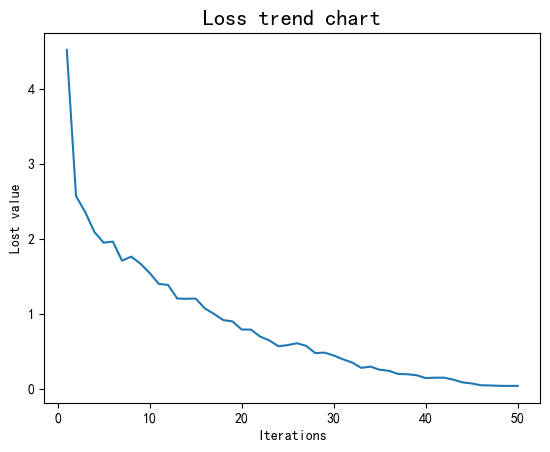

In [24]:
# Loss trend visualization
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # Set the font to bold
plt.rcParams['axes.unicode_minus'] = False  # Display Settings for characters
plt.plot(list(range(1, 51)), loss)  # Plot the loss value as a line chart
plt.title('Loss trend chart', fontsize=16)
plt.xlabel('Iterations')
plt.ylabel('Lost value')
plt.show()

In [25]:
import numpy as np

In [26]:
# Translate
def evaluate(sentence):
    '''
    sentence：sentences that need to be translated
    '''
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        # The predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [27]:
# Execute
def translate(sentence):
    '''
    sentence：sentences that need to be translated
    '''
    result, sentence, attention_plot = evaluate(sentence)
    processed_result = result.replace('<end>', '').strip()
    return '{}'.format(processed_result)
#     print('Input: %s' % (sentence))
#     print('translation result: {}'.format(result))

# Sentiment Analysis Based on LSTM

In [33]:
import pandas as pd
import nltk
from nltk import word_tokenize

In [30]:
data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')

# data = data_train.append(data_test, ignore_index=True)
data = pd.concat([data_train, data_test], ignore_index=True)

print(data.Emotion.value_counts())
data.head(6)

Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


In [34]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

data['Text'] = [' '.join(clean_text(text)) for text in data.Text]
data

,Emotion,Text
0,neutral,There are tons of other paintings that I think...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
...,...,...
11322,sadness,"My sweetheart left me , or rather we decided t..."
11323,sadness,"Well , it 's too bad that we like different ki..."
11324,neutral,It sure is .
11325,sadness,He ’ s got laid off again . I do feel sorry fo...


In [35]:
cut_word = lambda x: list(word_tokenize(x))
data['words'] = data['Text'].apply(cut_word)
data

,Emotion,Text,words
0,neutral,There are tons of other paintings that I think...,"[There, are, tons, of, other, paintings, that,..."
1,sadness,"Yet the dog had grown old and less capable , a...","[Yet, the, dog, had, grown, old, and, less, ca..."
2,fear,When I get into the tube or the train without ...,"[When, I, get, into, the, tube, or, the, train..."
3,fear,This last may be a source of considerable disq...,"[This, last, may, be, a, source, of, considera..."
4,anger,She disliked the intimacy he showed towards so...,"[She, disliked, the, intimacy, he, showed, tow..."
...,...,...,...
11322,sadness,"My sweetheart left me , or rather we decided t...","[My, sweetheart, left, me, ,, or, rather, we, ..."
11323,sadness,"Well , it 's too bad that we like different ki...","[Well, ,, it, 's, too, bad, that, we, like, di..."
11324,neutral,It sure is .,"[It, sure, is, .]"
11325,sadness,He ’ s got laid off again . I do feel sorry fo...,"[He, ’, s, got, laid, off, again, ., I, do, fe..."


In [36]:
w = []
for i in data['words']:
    w.extend(i)
dicts = pd.DataFrame(pd.Series(w).value_counts())

dicts['id'] = list(range(1, len(dicts)+1))

get_sent = lambda x: list(dicts['id'][x])
data['sent'] = data['words'].apply(get_sent)

In [38]:
from tensorflow.keras.preprocessing import sequence
maxlen = 40
data['sent'] = list(sequence.pad_sequences(data['sent'], maxlen=maxlen))

In [39]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
data['mark'] = [encoding[x] for x in data['Emotion']]

In [40]:
x_all = np.array(list(data['sent']))
y_all = np.array(list(data['mark']))

x_train, x_validation, y_train, y_validation = train_test_split(x_all, y_all, test_size=0.25)   

In [41]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_validation = to_categorical(y_validation)

print('train sent shape of data: ', x_train.shape)
print('train mark shape of data: ', y_train.shape)
print('validation sent shape of data: ', x_validation.shape)
print('validation mark shape of data: ', y_validation.shape)

print('train sent of data: \n', x_train)

train sent shape of data:  (8495, 40)
train mark shape of data:  (8495, 5)
validation sent shape of data:  (2832, 40)
validation mark shape of data:  (2832, 5)
train sent of data: 
 [[   0    0    0 ...   14  127    1]
 [   0    0    0 ... 1650 1540    1]
 [   0    0    0 ... 5241 3579    1]
 ...
 [   0    0    0 ...    6  104    1]
 [   0    0    0 ...   18   61   23]
 [   0    0    0 ...  202  389   81]]


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

In [43]:
# LSTM model
model = Sequential()
model.add(Embedding(len(dicts)+1, 256, input_length=maxlen))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

import time
# hyperparameter
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 256)           3642112   
                                                                 
 lstm (LSTM)                 (None, 40, 128)           197120    
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
 activation (Activation)     (None, 5)                 0

In [44]:
timeA = time.time()
model.fit(x_train, y_train, batch_size=16, epochs=10)
timeB = time.time()
print('time cost：', int(timeB-timeA))

Epoch 1/10
531/531 [==============================] - 33s 49ms/step - loss: 1.1890 - accuracy: 0.5089
Epoch 2/10
531/531 [==============================] - 25s 48ms/step - loss: 0.6031 - accuracy: 0.7972
Epoch 3/10
531/531 [==============================] - 27s 50ms/step - loss: 0.3634 - accuracy: 0.8825
Epoch 4/10
531/531 [==============================] - 28s 53ms/step - loss: 0.2566 - accuracy: 0.9230
Epoch 5/10
531/531 [==============================] - 28s 52ms/step - loss: 0.1831 - accuracy: 0.9462
Epoch 6/10
531/531 [==============================] - 28s 52ms/step - loss: 0.1427 - accuracy: 0.9595
Epoch 7/10
531/531 [==============================] - 27s 51ms/step - loss: 0.1227 - accuracy: 0.9644
Epoch 8/10
531/531 [==============================] - 28s 52ms/step - loss: 0.1042 - accuracy: 0.9669
Epoch 9/10
531/531 [==============================] - 28s 52ms/step - loss: 0.0919 - accuracy: 0.9725
Epoch 10/10
531/531 [==============================] - 28s 53ms/step - loss: 0.081

In [45]:
from sklearn import metrics

y_pred_prob = model.predict(x_validation)
y_pred = np.argmax(y_pred_prob, axis=1)

y_validation = np.argmax(y_validation, axis=1)

acc = metrics.accuracy_score(y_validation, y_pred)
print('accuracy of validation', acc)

print('precision, recall, F1 score: ')
print(metrics.classification_report(y_validation, y_pred))

print('confusion_matrix: ')
cm = metrics.confusion_matrix(y_validation, y_pred)
print(cm)

89/89 [==============================] - 3s 13ms/step
accuracy of validation 0.684322033898305
precision, recall, F1 score: 
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       603
           1       0.62      0.73      0.67       541
           2       0.64      0.63      0.63       566
           3       0.65      0.67      0.66       570
           4       0.80      0.75      0.77       552

    accuracy                           0.68      2832
   macro avg       0.69      0.69      0.69      2832
weighted avg       0.69      0.68      0.69      2832

confusion_matrix: 
[[393  59  43  59  49]
 [ 38 393  65  36   9]
 [ 28  80 356  73  29]
 [ 34  77  59 383  17]
 [ 39  27  33  40 413]]


# Text

In [49]:
text = "对不起。"
emotion_mapping = {0: 'joy', 1: 'fear', 2: 'anger', 3: 'sadness', 4: 'neutral'}
all_predictions = []

translation_result = translate(text)
translation_result

'i m sorry .'

In [50]:
cut_word = lambda x: word_tokenize(x)
translation_result=pd.DataFrame(pd.Series(translation_result))
translation_result['words'] = translation_result[0].apply(cut_word)

j = []
for i in translation_result['words']:
    j.extend(i)
dicts = pd.DataFrame(pd.Series(j).value_counts())
dicts['id'] = list(range(1, len(dicts)+1))
dicts

,count,id
i,1,1
m,1,2
sorry,1,3
.,1,4


In [51]:
get_sent = lambda x: list(dicts['id'][x])
translation_result['sent'] = translation_result['words'].apply(get_sent)
translation_result

,0,words,sent
0,i m sorry .,"[i, m, sorry, .]","[1, 2, 3, 4]"


In [59]:
translation_result['sent'] = list(sequence.pad_sequences(translation_result['sent'], maxlen=maxlen))

x_test = np.array(list(translation_result['sent']))

y_pred_test = model.predict(x_test)
y_pred = (y_pred_test > 0.5).astype(int)
y_pred = np.argmax(y_pred_prob, axis=1)

all_predictions.extend(y_pred)

emotion_counts = {emotion: all_predictions.count(index) for index, emotion in emotion_mapping.items()}
emotion = max(emotion_counts, key=emotion_counts.get)

print("Emotion:\t", emotion)

1/1 [==============================] - 0s 48ms/step
Emotion:	 fear
